In [1]:
!pip install --upgrade transformers

In [2]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import pandas as pd
import cv2
import numpy as np
import albumentations as aug

WIDTH = 512
HEIGHT = 512

2024-01-26 10:52:18.594123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 10:52:18.594175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 10:52:18.595320: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 10:52:18.601770: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 10:52:19.310235: W tensorflow/compiler/tf2

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from datasets import load_metric

In [35]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        self.transforms = transforms
        
        with open(self.classes_csv_file, 'r') as fid:
            data = [l.split(',') for i,l in enumerate(fid) if i != 0]
        self.id2label = {x[0]:x[1] for x in data}
        
        image_file_names = [f for f in os.listdir(self.root_dir) if '.jpg' in f]
        mask_file_names = [f for f in os.listdir(self.root_dir) if '.png' in f]
        
        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.images[idx])
        mask_path = os.path.join(self.root_dir, self.masks[idx])

        # 이미지 로드 확인
        image = Image.open(image_path)
        if image is None:
            raise ValueError(f"Failed to load image at {image_path}")

        # OpenCV 변환 확인
        image_np = np.array(image)
        if image_np is None:
            raise ValueError("Failed to convert image to NumPy array")

        # BGR에서 RGB로 변환
        image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

        segmentation_map = Image.open(mask_path).convert('L')
        
        if segmentation_map is None:
            raise ValueError(f"Failed to load segmentation map at {mask_path}")

        # OpenCV 변환 확인
        segmentation_map_np = np.array(segmentation_map)
        if segmentation_map_np is None:
            raise ValueError("Failed to convert segmentation map to NumPy array")

        # BGR에서 GRAY로 변환
        if len(segmentation_map_np.shape) == 3 and segmentation_map_np.shape[2] == 3:
            segmentation_map_gray = cv2.cvtColor(segmentation_map_np, cv2.COLOR_BGR2GRAY)
        else:
            segmentation_map_gray = segmentation_map_np

        # 나머지 코드
        encoded_inputs = self.feature_extractor(image_rgb, segmentation_map_gray, return_tensors="pt")
        
        for k, v in encoded_inputs.items():
            if k == "labels":
                encoded_inputs[k] = v.squeeze(dim=0)  # Squeeze the batch dimension for labels
            else:
                encoded_inputs[k].squeeze_()  # Remove batch dimension for other inputs

        return encoded_inputs


In [13]:
class SegformerFinetuner(pl.LightningModule):
  #pl.LightningModule : 훈련 루프, 옵티마이저, 콜백등을 통합하여 훈련을 더 쉽게 관리할 수 있게 도와줌.

    def __init__(self, id2label, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader

        self.num_classes = len(id2label.keys()) #149
        self.label2id = {v:k for k,v in self.id2label.items()} #키값과 레이블값의 위치를 바꾼 새로운 딕셔너리 생성

        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/mit-b5",
            return_dict=False, #모델 출력을 딕셔너리 형태로 반환하지 않도록 설정
            num_labels=self.num_classes, #num_labels = 149
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True, #크기가 일치하지 않는 입력은 무시
        )

        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")
        #검증 및 테스트 단계에서 발생한 출력을 저장하는 리스트
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, images, masks): #순전파 메소드
        #pixel_value : 이미지, labels : 해당 이미지에 대한 정답
        outputs = self.model(pixel_values=images, labels=masks)
        return(outputs)

    def training_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks) #self.forward(images, masks)와 동일

        #logits : softmax 함수 적용 전의 네트워크 출력을 의미, 픽셀 당 각 클래스에 대한 점수를 포함하는 텐서.
        loss, logits = outputs[0], outputs[1]

        #logits를 masks의 크기로 선형보간하여 얻은 업샘플링된 세그멘테이션 맵을 나타냄.
        #이는 후에 세그멘테이션 맵의 크기를 원래 입력 이미지 크기로 복원하는 데 사용됨.
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:], #업샘플링을 수행할 목표 크기를 지정. 여기서는 masks의 높이와 너비를 그대로 사용함.
            #tensor(배치크기, 채널수, 높이, 너비). 따라서 -2는 텐서의 높이와 너비를 나타냄
            mode="bilinear", #선형보간방법을 사용함.
            align_corners=False #선형보간시 정확한 코너 정렬이 아닌 중앙 정렬 사용.
        )

        #업샘플된 로짓에서 예측된 세그멘테이션 맵 생성.
        #argmax : 주어진 차원에서 가장 큰 값의 인덱스 반환. dim=1은 두번째 차원을 기준으로 하겠다는 의미.
        predicted = upsampled_logits.argmax(dim=1)

        #훈련 중 평가 메트릭 업데이트(IoU)
        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), #예측 결과 이용
            references=masks.detach().cpu().numpy() #실제 세그멘테이션 맵 이용
        )

        #일정한 간격으로 평가 메트릭을 로깅하고 반환
        if batch_nb % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes, #149
                ignore_index=255, #무시해야 하는 클래스의 인덱스를 나타냄. 해당 클래스는 평가 지표 계산에서 제외
                reduce_labels=False, #각 클래스에 대한 개별적 지표 반환.
            )

            #로깅할 메트릭 설정
            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}

            for k,v in metrics.items():
                self.log(k,v) # 평균 IoU와 손실을 기록하여 모델의 훈련 진행 상황 모니터링

            return(metrics)
        else:
            return({'loss': loss})

    def validation_step(self, batch, batch_nb): #위와 동일, 평가 메트릭 제외

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )

        # 검증 단계에서 계산된 각 배치의 손실을 저장하기 위한 리스트
        self.validation_step_outputs.append({'val_loss': loss}) #추가됨.

        return({'val_loss': loss})

    def on_validation_epoch_end(self): #평균 손실 및 다른 메트릭 계산
        #검증 데이터셋에 대한 IoU와 다른 관련 메트릭 계산
        metrics = self.val_mean_iou.compute(
              num_labels=self.num_classes, #149
              ignore_index=255,
              reduce_labels=False,
          )

        #평균 검증 손실 계산. outputs에 저장된 각 배치의 손실을 추출하고, torch.stack을 이용하여 하나의 텐서로 만든 후 평균 계산
        avg_val_loss = torch.stack([x["val_loss"] for x in self.validation_step_outputs]).mean()
        #앞서 계산한 IoU 값을 가져옴
        val_mean_iou = metrics["mean_iou"]
        #앞서 계산한 평균 정확도 값을 가져옴.
        val_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"val_loss": avg_val_loss, "val_mean_iou":val_mean_iou, "val_mean_accuracy":val_mean_accuracy}
        for k,v in metrics.items(): #평가 메트릭 로그에 기록
            self.log(k,v)

        self.validation_step_outputs.clear() #검증 손실을 계산한 배치별 출력 초기화. 다음 검증단계에서 새로운 손실값을 수집하기 위해.

        return metrics

    def test_step(self, batch, batch_nb): #valid_step과 동일

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )

        #테스트 단계에서 계산된 각 배치의 손실을 저장하기 위한 리스트
        self.test_step_outputs.append(loss) #추가됨

        return({'test_loss': loss})

    def on_test_epoch_end(self): #on_valid_epoch_end()와 유사

        #추가됨. 테스트과정에서 계산된 각 배치의 손실을 사용하여 전체 테스트 에폭에 대한 평균 테스트 손실 계산.
        epoch_average = torch.stack(self.test_step_outputs).mean()

        metrics = self.test_mean_iou.compute(
              num_labels=self.num_classes,
              ignore_index=255,
              reduce_labels=False,
          )

        avg_test_loss = torch.stack(self.test_step_outputs).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"test_loss": avg_test_loss, "test_mean_iou":test_mean_iou, "test_mean_accuracy":test_mean_accuracy}

        for k,v in metrics.items():
            self.log(k,v)

        self.test_step_outputs.clear()

        return metrics

    def configure_optimizers(self): #requires_grad속성이 true인 매개변수를 선택하여 해당 옵티마이저와 학습률 및 epsilon값을 설정하여 반환
        #아담 옵티마이저는 모멘텁 및 이동평균을 사용하여 가중치를 업데이트하는 최적화 알고리즘이다. eps는 분모에 더해지는 작은 상수.
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)

    def train_dataloader(self):
        return self.train_dl

    def val_dataloader(self):
        return self.val_dl

    def test_dataloader(self):
        return self.test_dl

In [14]:
transform = aug.Compose([
    aug.Flip(p=0.5)
])

root_dir = '/home/ubuntu/jiwon/teeth'
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b5")
feature_extractor.do_reduce_labels = False
feature_extractor.size = 128

train_dataset = ImageSegmentationDataset("/home/ubuntu/jiwon/teeth/train", feature_extractor=feature_extractor, transforms=transform)
val_dataset = ImageSegmentationDataset("/home/ubuntu/jiwon/teeth/valid", feature_extractor=feature_extractor, transforms=None)
test_dataset = ImageSegmentationDataset("/home/ubuntu/jiwon/teeth/test", feature_extractor=feature_extractor, transforms=None)

In [15]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 35
Number of validation examples: 4


In [16]:
encoded_inputs = train_dataset[0]

encoded_inputs["pixel_values"].shape

torch.Size([3, 128, 128])

In [17]:
encoded_inputs["labels"].shape

torch.Size([128, 128])

In [18]:

# Assuming that encoded_inputs["labels"] is a PyTorch tensor with shape torch.Size([1080, 128, 128])
labels_tensor = encoded_inputs["labels"]

# Squeeze the first dimension
labels_reshaped = torch.squeeze(labels_tensor, dim=0)

# Now, labels_reshaped should have the shape torch.Size([128, 128])
print(labels_reshaped.shape)


torch.Size([128, 128])


In [19]:
encoded_inputs["labels"]

tensor([[30, 30, 30,  ..., 30, 30, 30],
        [30, 30, 30,  ..., 30, 30, 30],
        [30, 30, 30,  ..., 30, 30, 30],
        ...,
        [30, 30, 30,  ..., 30, 30, 30],
        [30, 30, 30,  ..., 30, 30, 30],
        [30, 30, 30,  ..., 30, 30, 30]])

In [20]:
encoded_inputs["labels"].squeeze().unique()

tensor([ 30, 215])

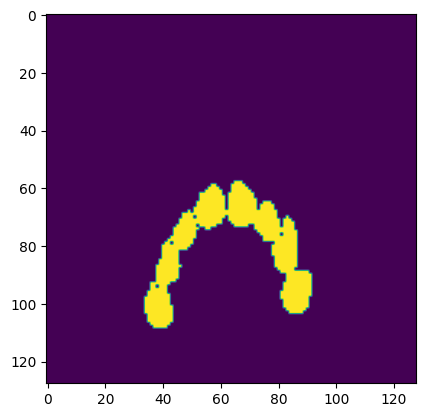

In [23]:
mask = encoded_inputs["labels"].numpy()

import matplotlib.pyplot as plt
plt.imshow(mask)


In [25]:
import torch
torch.cuda.empty_cache()

In [28]:
from torch.utils.data import DataLoader

batch_size = 4
num_workers = 1

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

batch = next(iter(train_dataloader))

segformer_finetuner = SegformerFinetuner(
    train_dataset.id2label,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    metrics_interval=10, #특정한 배치 수마다 훈련중에 모델의 성능을 기록
)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/jiwon/lib/python3.11/site-packages/datasets/load.py:752: FutureWarning: The repository for mean_iou contains custom code which must be exec

In [30]:
early_stop_callback = EarlyStopping( # min_delta 만큼의 변화가 없을 때 patience 횟수동안 기다린 후 조기종료
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
    verbose=False,
    mode="min",
)

# 검증 손실 모니터링, 가장 성능이 좋은 모델 저장. save_top_k : 저장할 최고 성능 모델의 수
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss")

# 훈련 담당 객체
trainer = pl.Trainer(
    callbacks=[early_stop_callback, checkpoint_callback], # 사용할 콜백 리스트로 저장
    max_epochs=200, # 최대 에폭 수
    val_check_interval=len(train_dataloader), # 검증 수행 간격 (여기서는 train_dataloader의 길이)
)
trainer.fit(segformer_finetuner) # segformer_finetuner 모델을 지정된 에폭 수만큼 훈련.

Trainer will use only 1 of 5 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=5)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [18]:
# 훈련된 모델의 최적 가중치를 불러와 테스트 데이터에 대한 성능 평가.
res = trainer.test(ckpt_path="best")

Restoring states from the checkpoint path at /home/ubuntu/jiwon/lightning_logs/version_3/checkpoints/epoch=99-step=400.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]
Loaded model weights from the checkpoint at /home/ubuntu/jiwon/lightning_logs/version_3/checkpoints/epoch=99-step=400.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0008362531661987305
   test_mean_accuracy               1.0
      test_mean_iou                 1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 1 is out of bounds for axis 0 with size 1

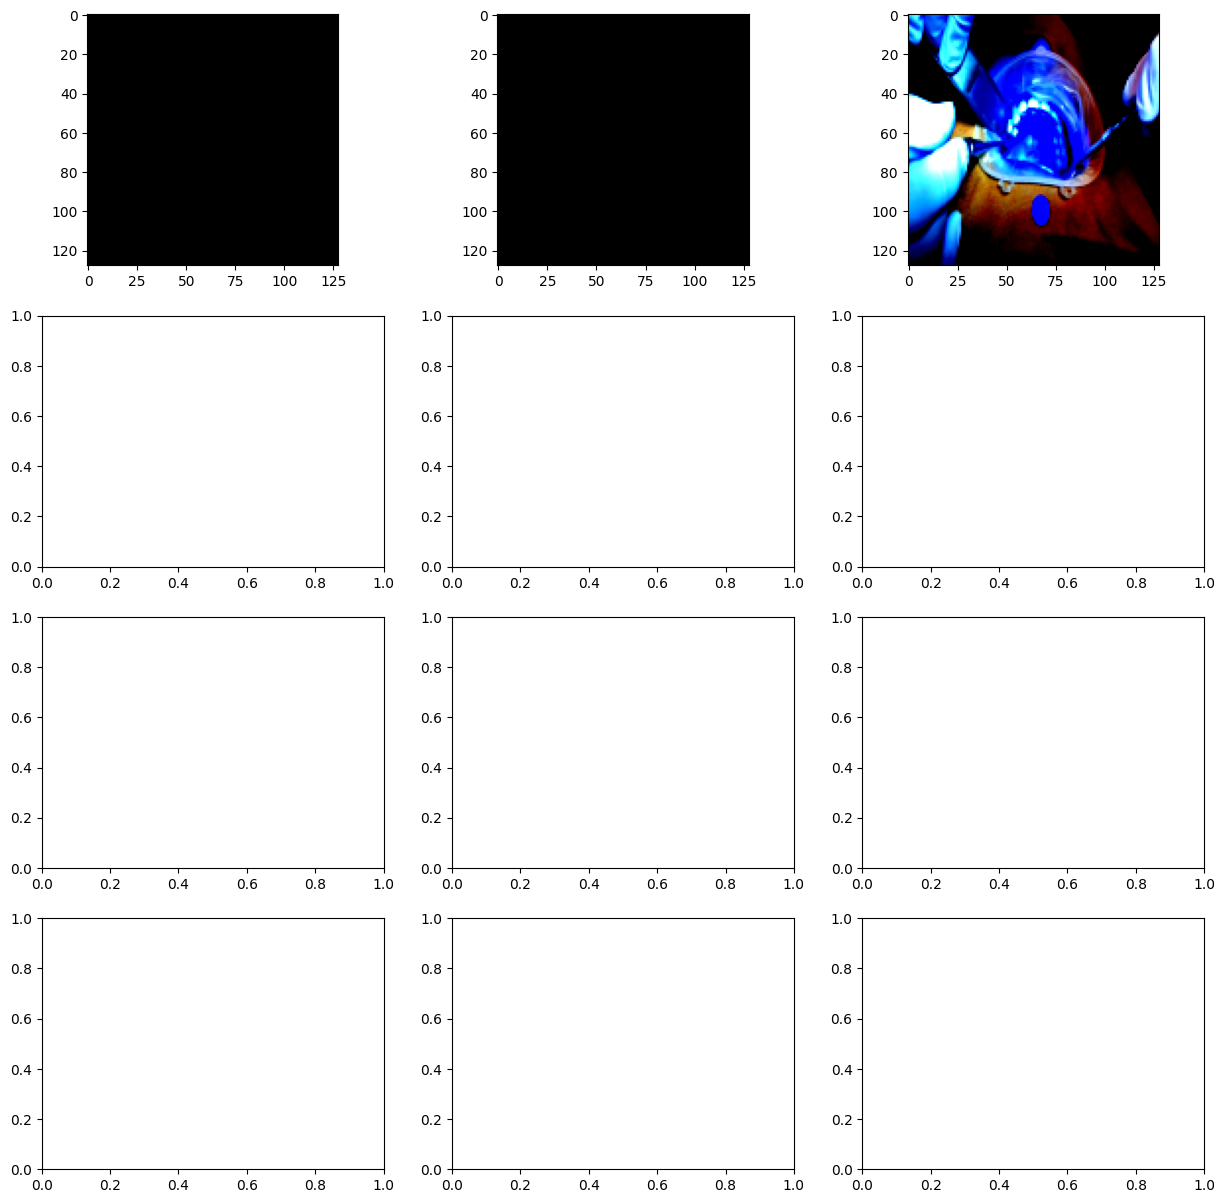

In [19]:
color_map = {
    0:(0,0,0), #검정
    1:(255,0,0), #빨강
}

def prediction_to_vis(prediction): #모델의 예측 맵을 시각적으로 표현하기 위한 함수
    vis_shape = prediction.shape + (3,) #예측맵 shape에 3 추가 -> 색상 채널(RGB)를 나타내는 차원을 만듦.
    vis = np.zeros(vis_shape) #0으로 초기회된 비어있는 이미지 생성
    for i,c in color_map.items(): #클래스 인덱스 i와 해당 클래스에 할당된 색상c를 가져옴.
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in test_dataloader: #테스트 데이터셋에 대해 배치 단위로 순환
    images, masks = batch['pixel_values'], batch['labels']
    #모델을 사용하여 입력 이미지에 대한 예측 수행. 이미지를 입력으로 받고, 해당 이미지에 대한 세그멘테이션 맵 출력
    outputs = segformer_finetuner.model(images, masks)

    loss, logits = outputs[0], outputs[1]

    upsampled_logits = nn.functional.interpolate(
        logits,
        size=masks.shape[-2:],
        mode="bilinear",
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
    masks = masks.cpu().numpy()

n_plots = 4
from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots,3)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    axarr[i,0].imshow(prediction_to_vis(predicted_mask[i,:,:]))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))
    # 원본 이미지 표시
    axarr[i,2].imshow(images[i].permute(1, 2, 0))  # 텐서의 차원을 조정하여 RGB 순서로 변경

# 각 subplot에 대한 타이틀 추가
axarr[0, 0].set_title('Predicted Mask')
axarr[0, 1].set_title('True Mask')
axarr[0, 2].set_title('Original Image')

plt.show()


In [34]:
#Predict on a test image and overlay the mask on the original image
# 테스트 데이터 중 하나에 대해 예측을 수행하고, 원본 이미지에 예측된 마스크를 오버레이하여 시각적으로 표시하는 과정.
test_idx = 0
input_image_file = "/home/ubuntu/jiwon/Balloons/test/12288355124_5e340d3de3_k_jpg.rf.9667946d7746f3ce964a4fc277e76b11.jpg"
input_image = Image.open(input_image_file)
test_batch = test_dataset[test_idx]
images, masks = test_batch['pixel_values'], test_batch['labels']
images = torch.unsqueeze(images, 0)
masks = torch.unsqueeze(masks, 0)
outputs = segformer_finetuner.model(images, masks)

loss, logits = outputs[0], outputs[1]

upsampled_logits = nn.functional.interpolate( # 로짓을 원래 마스크 크기로 업샘플링
    logits,
    size=masks.shape[-2:],
    mode="bilinear",
    align_corners=False
)
predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
mask = prediction_to_vis(np.squeeze(masks))
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)

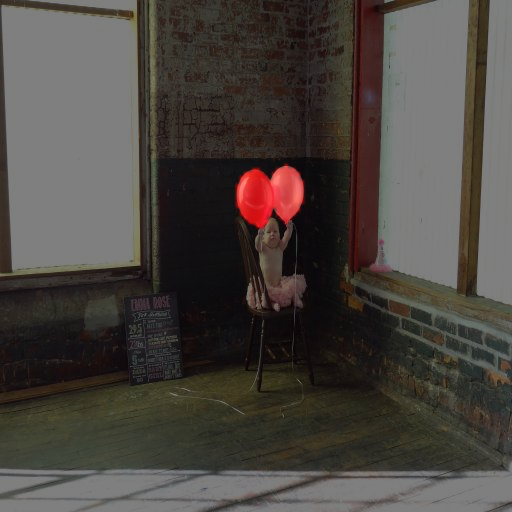

In [35]:
overlay_img

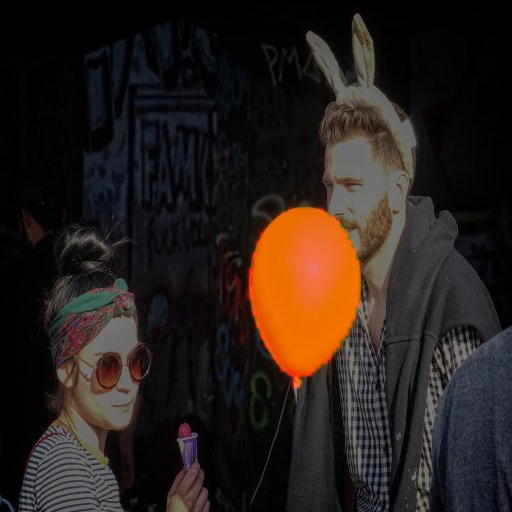

: 

In [45]:
#Predict on a test image and overlay the mask on the original image
# 테스트 데이터 중 하나에 대해 예측을 수행하고, 원본 이미지에 예측된 마스크를 오버레이하여 시각적으로 표시하는 과정.
test_idx = 4
input_image_file = "/home/ubuntu/jiwon/Balloons/test/34020010494_e5cb88e1c4_k_jpg.rf.108fae1c6e7446faa4e8a6599de3c860.jpg"
input_image = Image.open(input_image_file)
test_batch = test_dataset[test_idx]
images, masks = test_batch['pixel_values'], test_batch['labels']
images = torch.unsqueeze(images, 0)
masks = torch.unsqueeze(masks, 0)
outputs = segformer_finetuner.model(images, masks)

loss, logits = outputs[0], outputs[1]

upsampled_logits = nn.functional.interpolate( # 로짓을 원래 마스크 크기로 업샘플링
    logits,
    size=masks.shape[-2:],
    mode="bilinear",
    align_corners=False
)
predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
mask = prediction_to_vis(np.squeeze(masks))
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)

overlay_img